In [53]:
import matplotlib.gridspec as gridspec
import matplotlib.pylab as plt
import nanite
import numpy as np
import tqdm
from os import listdir
from os.path import isfile, join
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
import pandas as pd
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Conv2D, Conv1D, concatenate, MaxPooling1D
from keras.optimizers import Adam
from keras.utils import set_random_seed
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, auc


In [2]:
backward=0
group = nanite.load_group(rf"c:\Users\mcano\Code\rawdata\nanite_curves\annalisa\imgs\qi_MEC_P13_40000_zona1-data-2021.06.07-11.53.42.675.jpk-qi-data")

In [3]:
ncurves=40
lenvec=400
forces13=np.zeros((ncurves,lenvec))
zs13=np.zeros((ncurves,lenvec))
fits13=np.zeros((ncurves,lenvec))
for i in tqdm.tqdm(np.arange(ncurves)):
    idnt=group[i]
    idnt.apply_preprocessing(preprocessing=["compute_tip_position",
                                "correct_force_offset",
                                "correct_tip_offset","correct_force_slope"], 
                                options={'correct_tip_offset':{
                                    'method': 'fit_constant_line'
                                }})

    idnt.fit_properties["model_key"] = "sneddon_spher_approx"
    params = idnt.get_initial_fit_parameters()
    params["R"].value = 5e-06
    idnt.fit_model(params_initial=params)
    f=idnt["force"][idnt["segment"] == backward]*(1/1e-9)
    z=idnt["tip position"][idnt["segment"] == backward]*(1/1e-9)
    ft=idnt["fit"][idnt["segment"] == backward]*(1/1e-9)
    forces13[i,:len(f)]=f
    forces13[i,len(f):]=f[-1]
    zs13[i,:len(z)]=z
    zs13[i,len(z):]=z[-1]
    fits13[i,:len(ft)]=ft
    fits13[i,len(ft):]=ft[-1]


  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:07<00:00,  5.45it/s]


In [4]:
group = nanite.load_group(rf"c:\Users\mcano\Code\rawdata\nanite_curves\annalisa\imgs\qi_MEC_P20_40000_zona1-data-2021.06.07-12.32.03.685.jpk-qi-data")
ncurves=40
lenvec=400
forces20=np.zeros((ncurves,lenvec))
zs20=np.zeros((ncurves,lenvec))
fits20=np.zeros((ncurves,lenvec))
for i in tqdm.tqdm(np.arange(ncurves)):
    idnt=group[i]
    idnt.apply_preprocessing(preprocessing=["compute_tip_position",
                                "correct_force_offset",
                                "correct_tip_offset","correct_force_slope"], 
                                options={'correct_tip_offset':{
                                    'method': 'fit_constant_line'
                                }})

    idnt.fit_properties["model_key"] = "sneddon_spher_approx"
    params = idnt.get_initial_fit_parameters()
    params["R"].value = 5e-06
    idnt.fit_model(params_initial=params)
    f=idnt["force"][idnt["segment"] == backward]*(1/1e-9)
    z=idnt["tip position"][idnt["segment"] == backward]*(1/1e-9)
    ft=idnt["fit"][idnt["segment"] == backward]*(1/1e-9)
    forces20[i,:len(f)]=f
    forces20[i,len(f):]=f[-1]
    zs20[i,:len(z)]=z
    zs20[i,len(z):]=z[-1]
    fits20[i,:len(ft)]=ft
    fits20[i,len(ft):]=ft[-1]

100%|██████████| 40/40 [00:07<00:00,  5.14it/s]


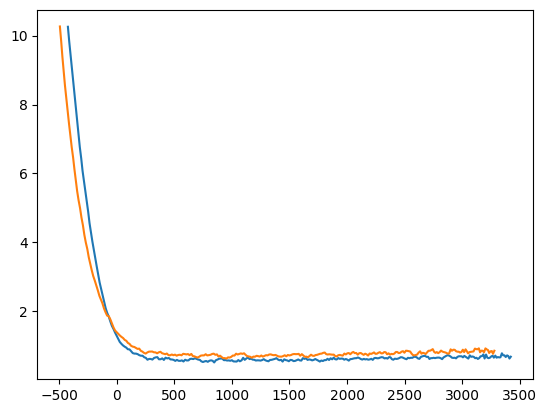

In [5]:
j=10
plt.plot(zs13[j], forces13[j])
plt.plot(zs20[j], forces20[j])

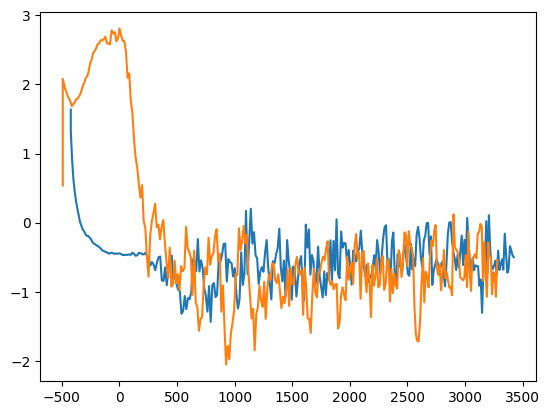

In [6]:
scaler=StandardScaler()
forces13_n=scaler.fit_transform(forces13)
scaler=StandardScaler()
forces20_n=scaler.fit_transform(forces20)
j=10
plt.plot(zs13[j], forces13_n[j])
plt.plot(zs20[j], forces20_n[j])

In [32]:
forces_mix=np.concatenate((forces13, forces20), axis=0)
zs_mix=np.concatenate((zs13, zs20), axis=0)
X=np.stack((forces_mix, zs_mix), axis=-1)
#X=np.expand_dims(X, axis=-1)
forces_mix_n=np.concatenate((forces13_n, forces20_n), axis=0)
zs_mix=np.concatenate((zs13, zs20), axis=0)
X_n=np.stack((forces_mix_n, zs_mix), axis=-1)



y13=np.zeros(len(forces13))
y20=np.zeros(len(forces13))+1
y=np.concatenate((y13,y20))
y=pd.DataFrame(y)

In [33]:
pctg=20

sss = ShuffleSplit(n_splits=1, test_size=1-(pctg/100), random_state=1)
sss.get_n_splits(X, y)
train_index, test_index = next(sss.split(X, y))
train_index=np.sort(train_index)  
test_index=np.sort(test_index)  



X_train, X_test = X[train_index], X[test_index] 
y_train, y_test = np.array(y.iloc[train_index]), np.array(y.iloc[test_index])

In [62]:
kernel_dim=2
batch_sz=10
iterations=100

set_random_seed(1)

# inp_cv=Input(shape=(np.shape(X[0])))

# cv=Conv1D(filters=32, kernel_size=(kernel_dim), activation='relu')(inp_cv)
# cv=MaxPooling1D(pool_size=2)(cv)
# cv=Flatten()(cv)
# cv=Dense(256,activation ="relu")(cv)
# out=Dense(1)(cv)
# cv=Model(inputs=inp_cv, outputs=cv)


# reg = Model(inputs=[cv.input], outputs=out)

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=11, activation='relu', input_shape=(lenvec, 2)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])
histo=model.fit(X_train, y_train[:,0], batch_size=batch_sz, epochs=iterations, validation_data=[X_test,y_test[:,0]], verbose=1)

c:\Users\mcano\Code\FAST\fast_smart_scanning\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 390, 32)        │           736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 195, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 6240)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │       798,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 808,897 (3.09 MB)

 Trainable params: 808,897 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step - accuracy: 0.2000 - loss: 167.3848 - val_accuracy: 0.4375 - val_loss: 80.1584
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8000 - loss: 44.8250 - val_accuracy: 0.4375 - val_loss: 154.1343
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8000 - loss: 53.7957 - val_accuracy: 0.4375 - val_loss: 135.2620
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8000 - loss: 42.1805 - val_accuracy: 0.4375 - val_loss: 70.8218
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8000 - loss: 15.1477 - val_accuracy: 0.5625 - val_loss: 20.9501
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2000 - loss: 39.5217 - val_accuracy: 0.5625 - val_loss: 17.9218
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2000 - loss: 29.1585 - val_accuracy: 0.4375 - val_loss: 19.7302
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8000 - loss: 8.8170 - val_accuracy: 

In [63]:
res=model.predict(X_test)
th=0.5
res[res > th]=1
res[res <= th]=0

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


In [64]:
tn, fp, fn, tp = confusion_matrix(y_test, res).ravel()

# Calculate specificity
specificity = tn / (tn + fp)
accuracy = (tn+tp) / (tn + fp +tp+fn)
print(accuracy)
print(specificity)

0.625
0.7857142857142857


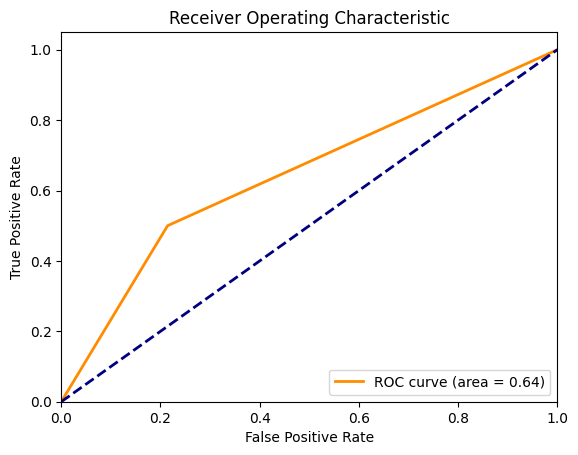

In [65]:
fpr, tpr, thresholds = roc_curve(y_test, res)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()